# Demand Forecasting for ATMs

The bank has recently expanded its operations to a new region. The ATM operations manager is interested in predicting the demand for the ATMs one week ahead to ensure adequate resources and a positive user experience.

## Data Description

- **BN_20**: remaining amount in bill notes of 20 euros
- **BN_50**: remaining amount in bill notes of 50 euros
- **Cash Out**: displays the cumulative total of the amount withdrawn
- **Remaining Amount**: amount available for cash-out.
- **Status**: ATM service status (up/down).
- **datetime**: date and time values were recorded.

## Data Preparation

In [1]:
!pip install pipreqs


  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=7eaba6cbe5f4b7454a4d76c711733db263df03769453fbeae9bfaf8bb433fb50
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from IPython.display import display
from PIL import Image

In [3]:
# Read data from Excel file
#data = pd.read_excel("/content/drive/MyDrive/Alpha_Case_Studies/Case studies/ATM_data.xlsx")
data = pd.read_excel("ATM_data.xlsx")
data.head()

,BN_20,BN_50,Cash Out,Remaining Amount,Status,datetime
0,19880,49150,970,69030,UP,2022-02-18 08:00:00
1,19740,49050,1210,68790,UP,2022-02-21 08:00:00
2,19720,49050,1230,68770,UP,2022-02-22 08:00:00
3,19640,48950,1410,68590,UP,2022-02-23 08:00:00
4,19640,48350,2010,67990,UP,2022-02-24 08:00:00


In [4]:
data = data.drop(columns = ['Status'])
data20 = data.drop(columns = ['BN_50','Cash Out', 'Remaining Amount']) #for further modelling
data50 = data.drop(columns = ['BN_20','Cash Out', 'Remaining Amount']) #for further modelling

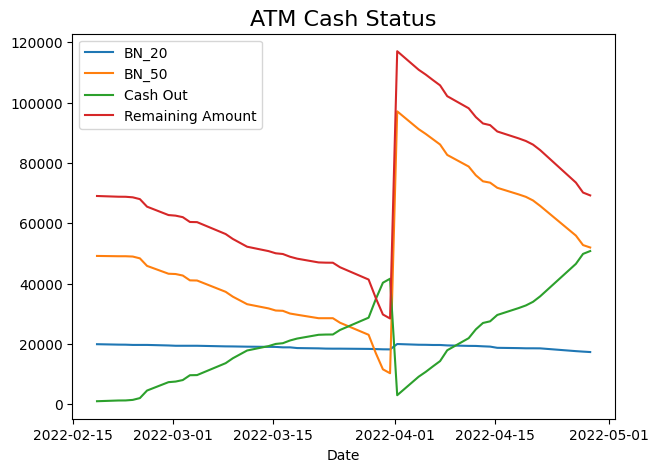

<Figure size 640x480 with 0 Axes>

In [5]:
plt.figure(figsize=(7, 5))
plt.plot( data['datetime'], data['BN_20'], label='BN_20')
plt.plot( data['datetime'], data['BN_50'],  label='BN_50')
plt.plot( data['datetime'], data['Cash Out'], label='Cash Out')
plt.plot( data['datetime'], data['Remaining Amount'],  label='Remaining Amount')
plt.title("ATM Cash Status", fontsize=16)
plt.legend()
plt.xlabel("Date");
plt.savefig('ATM_Cash_Status.png')
plt.show()
plt.clf()

In [6]:
data = data.drop(columns = ['BN_20','BN_50', 'Cash Out'])

In [7]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Scale the data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Remaining Amount']])
scaled_test_data = scaler.transform(test_data[['Remaining Amount']])
true_test_data = test_data['Remaining Amount']
datetime_test = test_data['datetime']

## Models

### ML Models

In [8]:
# ARIMA model
arima_model = ARIMA(train_data['Remaining Amount'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [9]:
# SARIMA model
sarima_model = SARIMAX(train_data['Remaining Amount'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
sarima_model_fit = sarima_model.fit()
sarima_predictions = sarima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [10]:
# Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor()
gbr_model.fit(np.arange(len(train_data)).reshape(-1, 1), train_data['Remaining Amount'])
gbr_predictions = gbr_model.predict(np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1))

### LSTM

In [11]:
# Creating a simple LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(np.expand_dims(scaled_train_data, axis=-1),
                              np.expand_dims(scaled_train_data, axis=-1),
                              epochs=10, batch_size=1, verbose=0)
lstm_predictions = lstm_model.predict(np.expand_dims(scaled_test_data, axis=-1))

1/1 [==============================] - 1s 774ms/step


Epoch 1/10
14/14 [==============================] - 8s 62ms/step - loss: 0.2194 - val_loss: 0.2158
Epoch 2/10
14/14 [==============================] - 0s 9ms/step - loss: 0.1389 - val_loss: 0.1327
Epoch 3/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0692 - val_loss: 0.0561
Epoch 4/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0363 - val_loss: 0.0383
Epoch 5/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0274 - val_loss: 0.0326
Epoch 6/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0217 - val_loss: 0.0280
Epoch 7/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0173 - val_loss: 0.0226
Epoch 8/10
14/14 [==============================] - 0s 10ms/step - loss: 0.0143 - val_loss: 0.0170
Epoch 9/10
14/14 [==============================] - 0s 10ms/step - loss: 0.0107 - val_loss: 0.0126
Epoch 10/10
1/1 [==============================] - 1s 794ms/step


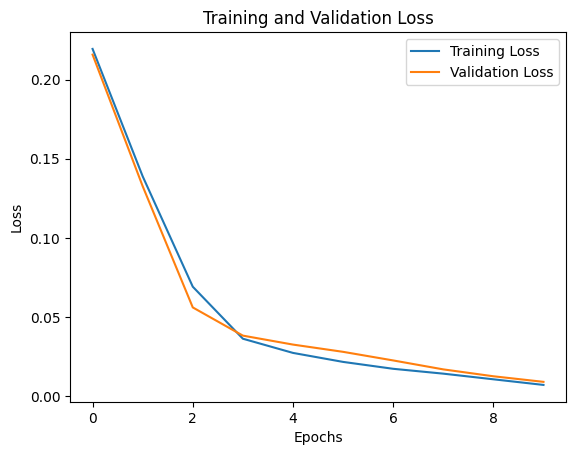

<Figure size 640x480 with 0 Axes>

In [12]:
# Create a more complex LSTM
def create_lstm_model_new():
    model = Sequential()
    model.add(LSTM(128, input_shape=(1, 1),return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    np.expand_dims(scaled_train_data, axis=-1),
    np.expand_dims(scaled_train_data, axis=-1),
    test_size=0.2,
    random_state=42
)

# Create and train the model with validation set
lstm_model_new = create_lstm_model_new()
lstm_history_new = lstm_model_new.fit(X_train, y_train,
    epochs=10,
    batch_size=2,
    validation_data=(X_val, y_val),
    verbose=1
)

# Predict on the test set
lstm_predictions_new = lstm_model_new.predict(np.expand_dims(scaled_test_data, axis=-1))

# Plot training and validation loss
plt.plot(lstm_history_new.history['loss'], label='Training Loss')
plt.plot(lstm_history_new.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.clf()

Since the train and validation losses are similar we can safely assume there is no **overfitting**

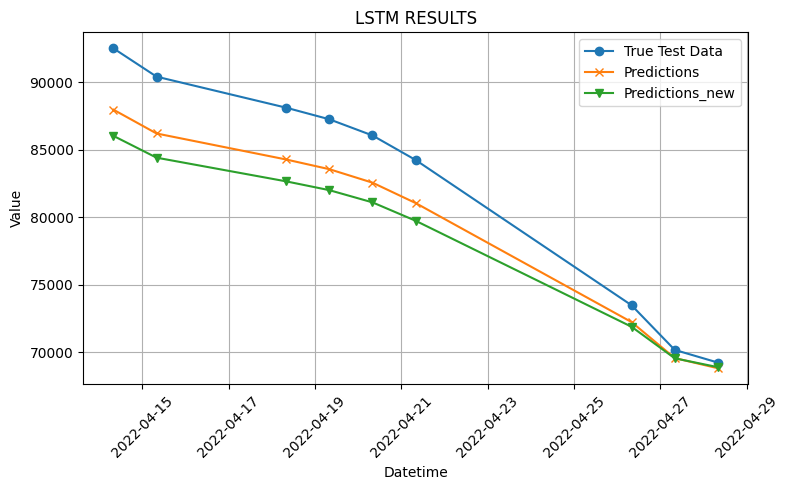

<Figure size 640x480 with 0 Axes>

In [13]:
# Inverse scaling the test data and predictions to their original scale
unscaled_test_data = scaler.inverse_transform(scaled_test_data)
lstm_unscaled_predictions = scaler.inverse_transform(lstm_predictions)
unscaled_predictions_new = scaler.inverse_transform(lstm_predictions_new)

# Plotting the actual values (true_test_data) and predicted values (unscaled_predictions)
plt.figure(figsize=(8, 5))
plt.plot(datetime_test, true_test_data, label='True Test Data', marker='o')
plt.plot(datetime_test, lstm_unscaled_predictions, label='Predictions', marker='x')
plt.plot(datetime_test, unscaled_predictions_new, label='Predictions_new', marker='v')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('LSTM RESULTS')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.clf()

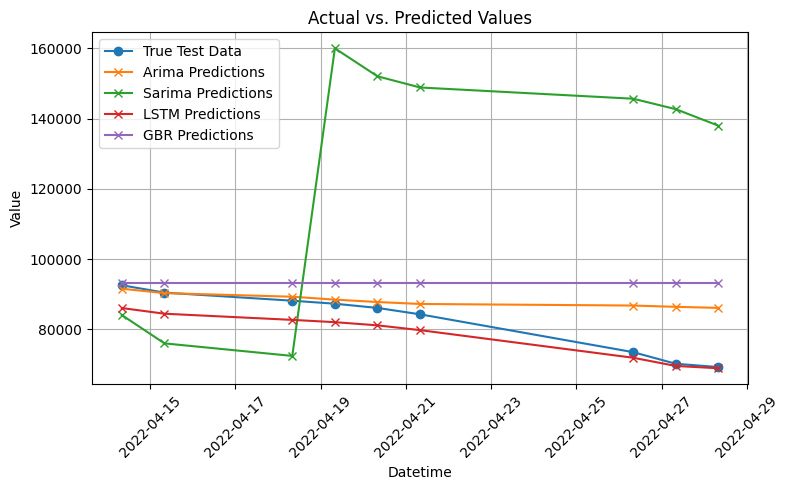

<Figure size 640x480 with 0 Axes>

In [14]:
# Plotting the actual values and predicted values of all models
plt.figure(figsize=(8, 5))
plt.plot(datetime_test, true_test_data, label='True Test Data', marker='o')
plt.plot(datetime_test, arima_predictions, label='Arima Predictions', marker='x')
plt.plot(datetime_test, sarima_predictions, label='Sarima Predictions', marker='x')
plt.plot(datetime_test, unscaled_predictions_new, label='LSTM Predictions', marker='x')
plt.plot(datetime_test, gbr_predictions, label='GBR Predictions', marker='x')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.clf()

**Sarima** predictions are way off, so in order to observe better the results, it will not be taken into consideration in the next plot.
**GBR** predictions are also worse than the other 2 models. So, it will not be taken into consideration in the next plot.

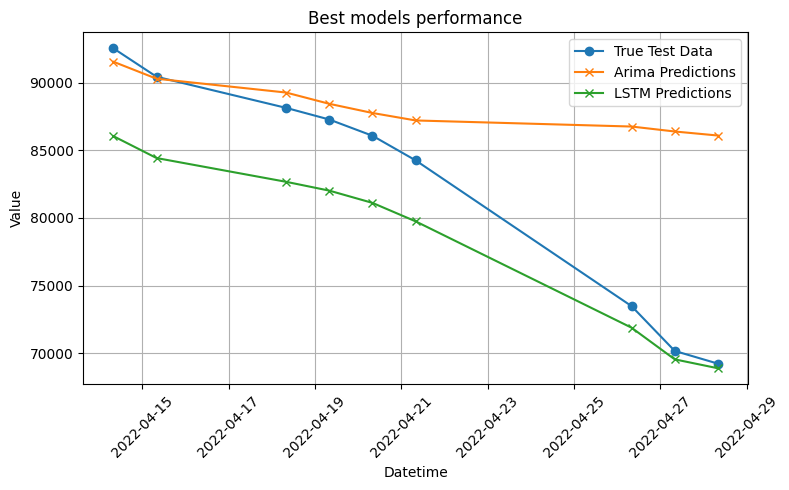

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(datetime_test, true_test_data, label='True Test Data', marker='o')
plt.plot(datetime_test, arima_predictions, label='Arima Predictions', marker='x')
plt.plot(datetime_test, unscaled_predictions_new, label='LSTM Predictions', marker='x')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('Best models performance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Best_models_full_data.png')
plt.show()
plt.clf()

In [16]:
# Calculate RMSE for each model
arima_rmse = np.sqrt(mean_squared_error(test_data['Remaining Amount'], arima_predictions))
sarima_rmse = np.sqrt(mean_squared_error(test_data['Remaining Amount'], sarima_predictions))
lstm_rmse = np.sqrt(mean_squared_error(test_data['Remaining Amount'], lstm_predictions))
gbr_rmse = np.sqrt(mean_squared_error(test_data['Remaining Amount'], gbr_predictions))

# Print the RMSE values
print(f"ARIMA RMSE: {arima_rmse}")
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"LSTM RMSE: {lstm_rmse}")
print(f"Gradient Boosting Regressor RMSE: {gbr_rmse}")

ARIMA RMSE: 9057.49063923112
SARIMA RMSE: 57286.07501390107
LSTM RMSE: 82827.46919244001
Gradient Boosting Regressor RMSE: 13623.941593758018


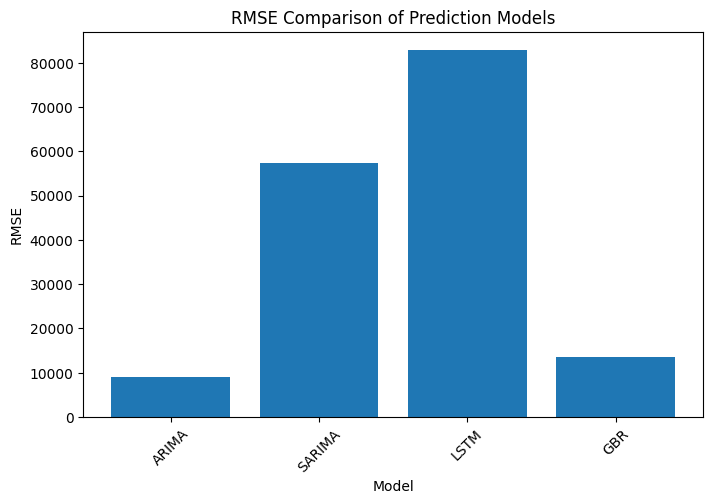

<Figure size 640x480 with 0 Axes>

In [17]:
# Define the models and RMSE values
models = ['ARIMA', 'SARIMA', 'LSTM', 'GBR']
rmse_values = [arima_rmse, sarima_rmse, lstm_rmse, gbr_rmse]

# Plot the bar graph
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values)
plt.title('RMSE Comparison of Prediction Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.savefig('RMSE.png')
plt.show()

plt.clf()

`Note`: Other metrics were also taken into consideration but RMSE shows the error differences more clearly.

## Models for BN_20 & BN_50

### BN_20

In [18]:
# Split data into train and test sets
train_size = int(len(data20) * 0.8)
train_data20, test_data20 = data20[:train_size], data20[train_size:]

# Scale the data
scaler20 = MinMaxScaler()
scaled_train_data20 = scaler.fit_transform(train_data20[['BN_20']])
scaled_test_data20 = scaler.transform(test_data20[['BN_20']])
true_test_data20 = test_data20['BN_20']
datetime_test20 = test_data20['datetime']

In [19]:
# ARIMA model
arima_model20 = ARIMA(train_data20['BN_20'], order=(1, 1, 1))
arima_model_fit20 = arima_model20.fit()
arima_predictions20 = arima_model_fit20.predict(start=len(train_data20), end=len(train_data20) + len(test_data20) - 1)

Epoch 1/10
14/14 [==============================] - 4s 58ms/step - loss: 0.3672 - val_loss: 0.2108
Epoch 2/10
14/14 [==============================] - 0s 8ms/step - loss: 0.2361 - val_loss: 0.1033
Epoch 3/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0827 - val_loss: 0.0278
Epoch 4/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0323 - val_loss: 0.0467
Epoch 5/10
14/14 [==============================] - 0s 6ms/step - loss: 0.0288 - val_loss: 0.0227
Epoch 6/10
14/14 [==============================] - 0s 8ms/step - loss: 0.0205 - val_loss: 0.0194
Epoch 7/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0160 - val_loss: 0.0179
Epoch 8/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 9/10
14/14 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 10/10
1/1 [==============================] - 1s 631ms/step


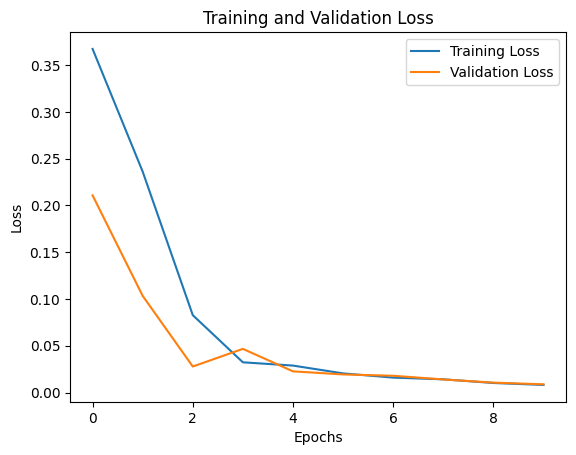

In [20]:
# Split data into training and validation sets
X_train20, X_val20, y_train20, y_val20 = train_test_split(
    np.expand_dims(scaled_train_data20, axis=-1),
    np.expand_dims(scaled_train_data20, axis=-1),
    test_size=0.2,
    random_state=42
)

# Create and train the model with validation set
lstm_model20 = create_lstm_model_new()
lstm_history20= lstm_model20.fit(X_train20, y_train20,
    epochs=10,
    batch_size=2,
    validation_data=(X_val20, y_val20),
    verbose=1
)

# Predict on the test set
lstm_predictions20 = lstm_model20.predict(np.expand_dims(scaled_test_data20, axis=-1))


# Plot training and validation loss
plt.plot(lstm_history20.history['loss'], label='Training Loss')
plt.plot(lstm_history20.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

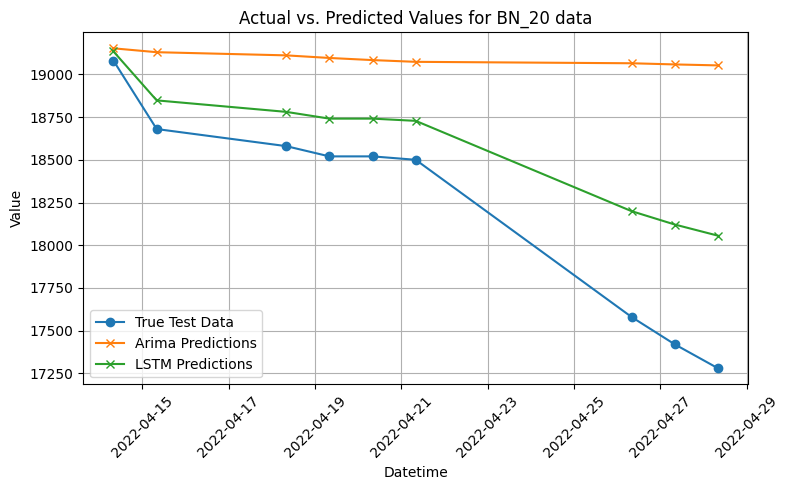

<Figure size 640x480 with 0 Axes>

In [21]:
# Plotting the actual values (true_test_data) and predicted values (unscaled_predictions)
lstm_predictions20_unscalled = scaler.inverse_transform(lstm_predictions20)

plt.figure(figsize=(8, 5))
plt.plot(datetime_test20, true_test_data20, label='True Test Data', marker='o')
plt.plot(datetime_test20, arima_predictions20, label='Arima Predictions', marker='x')
plt.plot(datetime_test20, lstm_predictions20_unscalled, label='LSTM Predictions', marker='x')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values for BN_20 data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Models_20_data.png')
plt.show()

plt.clf()

### BN_50

In [22]:
# Split data into train and test sets
train_size = int(len(data50) * 0.8)
train_data50, test_data50 = data50[:train_size], data50[train_size:]

# Scale the data
scaler50 = MinMaxScaler()
scaled_train_data50 = scaler.fit_transform(train_data50[['BN_50']])
scaled_test_data50 = scaler.transform(test_data50[['BN_50']])
true_test_data50 = test_data50['BN_50']
datetime_test50 = test_data50['datetime']

In [23]:
# ARIMA model
arima_model50 = ARIMA(train_data50['BN_50'], order=(1, 1, 1))
arima_model_fit50 = arima_model50.fit()
arima_predictions50 = arima_model_fit50.predict(start=len(train_data50), end=len(train_data50) + len(test_data50) - 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Epoch 1/10
14/14 [==============================] - 5s 60ms/step - loss: 0.2117 - val_loss: 0.2147
Epoch 2/10
14/14 [==============================] - 0s 6ms/step - loss: 0.1418 - val_loss: 0.1272
Epoch 3/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0688 - val_loss: 0.0566
Epoch 4/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0293 - val_loss: 0.0389
Epoch 5/10
14/14 [==============================] - 0s 6ms/step - loss: 0.0294 - val_loss: 0.0332
Epoch 6/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0232 - val_loss: 0.0283
Epoch 7/10
14/14 [==============================] - 0s 8ms/step - loss: 0.0166 - val_loss: 0.0221
Epoch 8/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0136 - val_loss: 0.0163
Epoch 9/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0124
Epoch 10/10
1/1 [==============================] - 1s 632ms/step


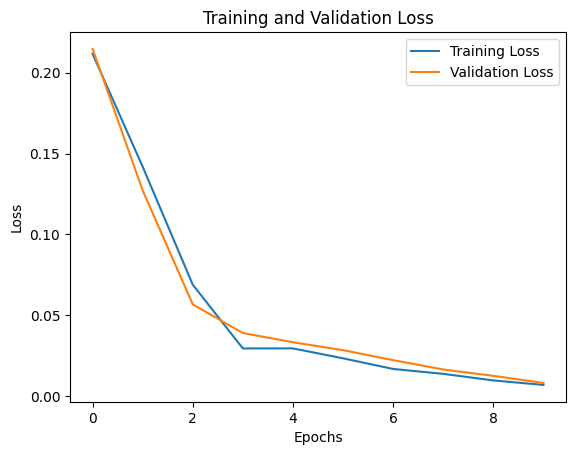

In [24]:
# Split data into training and validation sets
X_train50, X_val50, y_train50, y_val50 = train_test_split(
    np.expand_dims(scaled_train_data50, axis=-1),
    np.expand_dims(scaled_train_data50, axis=-1),
    test_size=0.2,
    random_state=42
)

# Create and train the model with validation set
lstm_model50 = create_lstm_model_new()
lstm_history50= lstm_model50.fit(X_train50, y_train50,
    epochs=10,
    batch_size=2,
    validation_data=(X_val50, y_val50),
    verbose=1
)
# Predict on the test set
lstm_predictions50 = lstm_model50.predict(np.expand_dims(scaled_test_data50, axis=-1))



# Plot training and validation loss
plt.plot(lstm_history50.history['loss'], label='Training Loss')
plt.plot(lstm_history50.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

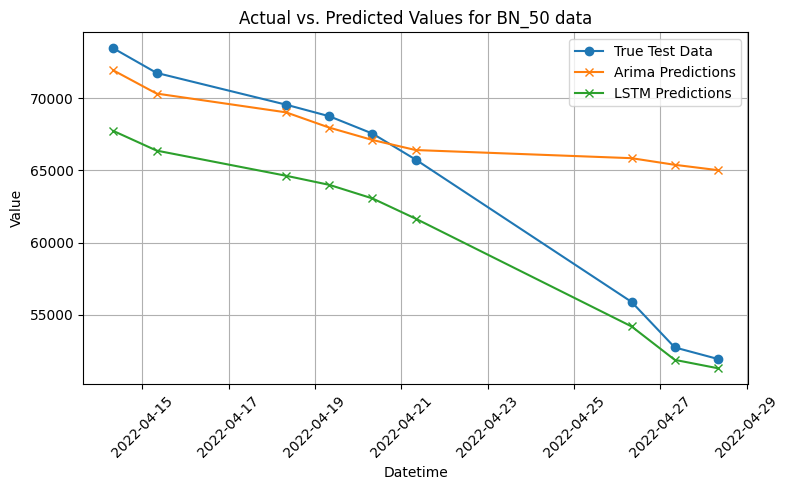

<Figure size 640x480 with 0 Axes>

In [25]:
# Plotting the actual values (true_test_data) and predicted values (unscaled_predictions)
lstm_predictions50_unscalled = scaler.inverse_transform(lstm_predictions50)


plt.figure(figsize=(8, 5))
plt.plot(datetime_test50, true_test_data50, label='True Test Data', marker='o')
plt.plot(datetime_test50, arima_predictions50, label='Arima Predictions', marker='x')
plt.plot(datetime_test50, lstm_predictions50_unscalled, label='LSTM Predictions', marker='x')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values for BN_50 data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Models_50_data.png')
plt.show()
plt.clf()

## Analyze the model results and provide insights gained during the modeling process

In [26]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({'Model': models, 'RMSE': rmse_values})
results_df_sorted = results_df.sort_values(by='RMSE')

# Format RMSE values to two decimal places
results_df_sorted['RMSE'] = results_df_sorted['RMSE'].round(2)

# Display the results
print(results_df_sorted)

    Model      RMSE
0   ARIMA   9057.49
3     GBR  13623.94
1  SARIMA  57286.08
2    LSTM  82827.47


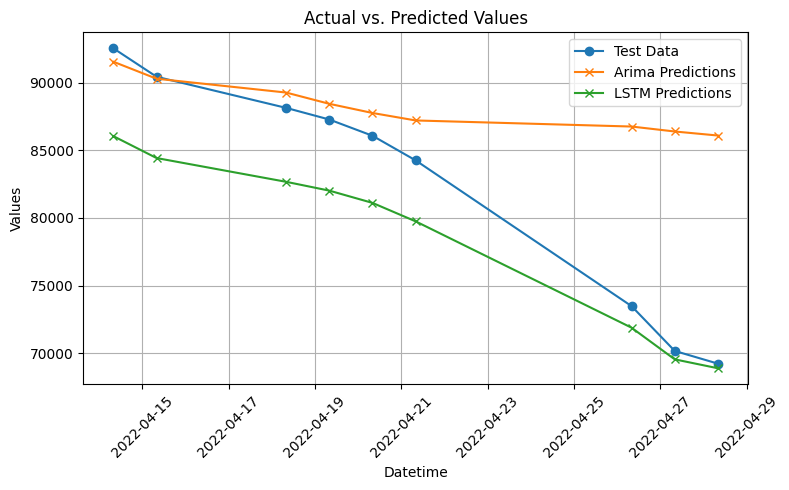

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(datetime_test, true_test_data, label='Test Data', marker='o')
plt.plot(datetime_test, arima_predictions, label='Arima Predictions', marker='x')
plt.plot(datetime_test, unscaled_predictions_new, label='LSTM Predictions', marker='x')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.clf()

Although, the results of the **RMSE** metric show that `ARIMA` is by far the best performing model, and `LSTM` is the worse. It is interesting that when observing the actual predictions, this conclusion cannot be easily seen. While for **1 week** predictions the `Arima` model outperfoms all the others, in the long term `LSTM` follows better the test set. </br>
Furthermore, that is also the case when predicting the amount of money in 50 euro bills left in the ATM machine. However, when the same models are trained in the train set for 20 euro bills left in the ATM, `LSTM` outperforms all the other models during the entire test set. </br>
In conclusion, ARIMA and LSTM are the best performing models depending on the use, and their results are depended vastly on the data provided.

## Results

### Aproach Taken
In order to be able to build a model that predicts the cash-out demand for the ATMs in the new region, first the data must be understood. The easiest method, is to visualize them!

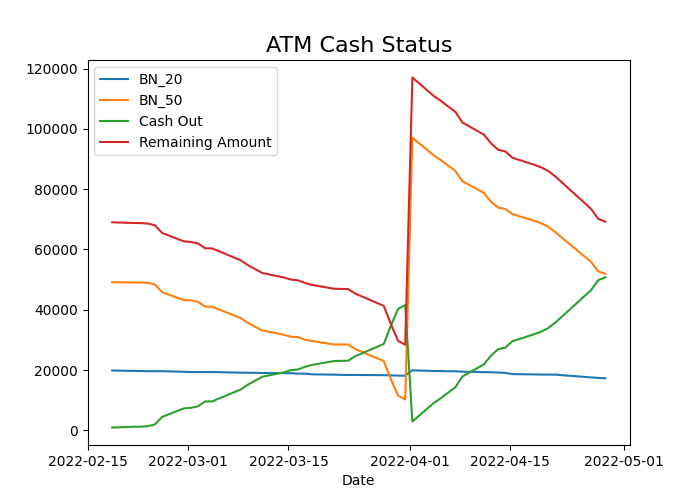

In [28]:
display(Image.open('ATM_Cash_Status.png'))

In the image above can be seen the amount in leftover money in 20 euro bills (BN_20), in 50 euro bills (BN_50), the total **Remaining Amount** of cash left in the ATM as well as the Cash withdrawn. </br>
After observing thise image, it can be understood that, as more money is withdrawn, the total remaining amount is decreasing. But, it's interesting as the blue line (BN_20), is decreasing very slowly while the orange line has a parallel course with the Remaining Amount. It is safe to say, that there is more demand for 50 euro bills rather than 20 bills. </br>
The large spike at `2022-04-01`, likely is a refill of the ATM. Moreover, for the entire period of data, the ATM was always available. </br>
Taking everything into consideration, models mainly based on data from the total Remaining Amount were trained. Although, the remaining amount of each bill is important, the main variable that should be taken into consideration is the total amount of cash since the ATM can remain functional without one of the two bills. **BUT** as positive user experience is important those attributes were also taken into consideration at a later stage of the process.</br>
After selecting the appropriate models for this task, experiments were produced to train the best possible model. After, training and evaluating all the models the best ones were selected to be used for further experimentation. As said before, positive user experience is at most important, so the best models were also trained in dataset which is made of data of only 20 euro bills as well as a dataset of only 50 euro bills.



### Results Obtained
Models were trained and test, but after the evaluation only two models were good enough to be presented, `ARIMA` & `LSTM`. Both models, have presented promising results but each has it's strengths and weaknesses as you will see in the image below. </br>
- ARIMA: follows closely the true values in a weeks predictions
- LSTM: is better for long term predictions

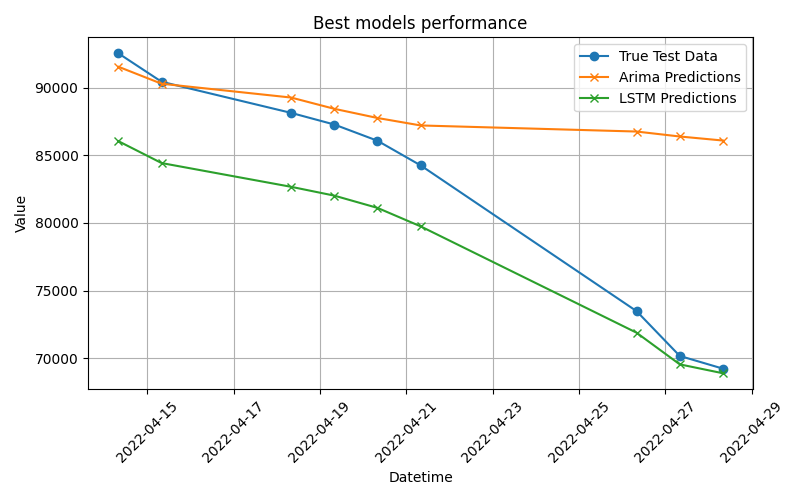

In [29]:
display(Image.open('Best_models_full_data.png'))

These two models are also trained in BN_20 Data and BN_50 data. The strengths and weaknesses mention above follow the models in the BN_50 dataset, but not in the BN_20 dataset.

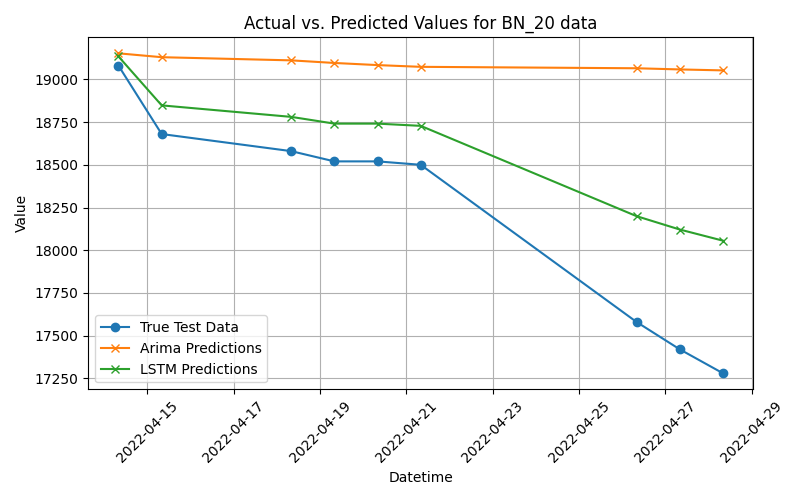

In [30]:
display(Image.open('Models_20_data.png'))

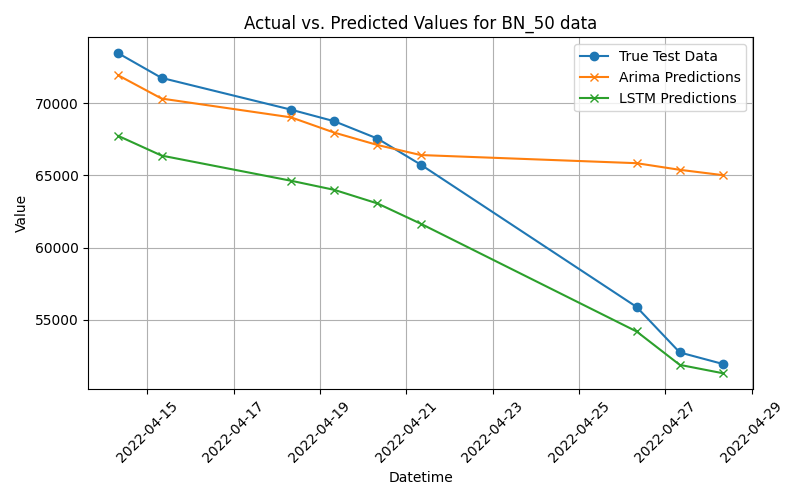

In [31]:
display(Image.open('Models_50_data.png'))

### Limitation and Suggestions
- **Limitations**: the main limitation of this project is the data available. Despite having data from only 45 days, both models performed unexpectedly well.
- **Suggestions**: since LSTM is performing adequately, and better in the BN_20 dataset, I recommend it as the best all around model. Although, Arima performs better in the short term it's predicted remaining amount was always higher than LSTMs and almost every time more that the actual amount. Which means that even though it performs better is more prone to making an error as it predicts later dates. With that said using the LSTM can be proven safer and more future resilient. </br>
As the needs of the bank increase, so may it's need for forecasting more dates ahead. So, picking a model like LSTM can be an investment, and save resources logn term while giving accurete predictions in the present while continuously getting trained with more data.


## Recommendations

To optimize the ATM operation in the new region my recommendation would be transfer learning. To achieve this, the steps needed are:
1. Get data from neighboring regions or even in a wider range
2. Train the model in that data
3. Freeze the layers of the model
4. Add new trainable layers and train them
5. Fine-tune the model
6. Continue to train the model at regular intervals with data extracted from the new region.
